Survivors Classification on Titanic using  R
===

Wesley Nogueira Galvão 

July, 2019

# Introduction

# Question definition

# Data

## Data Dictionary

|Variable |Definition|Key|
|:---- |----|----:|
|survival  | Survival |0 = No, 1 = Yes|
|pclass |Ticket class| 1 = 1st, 2 = 2nd, 3 = 3rd|
|sex  |Sex| 	
|Age  | Age in years| 	
|sibsp| # of siblings / spouses aboard the Titanic |
|parch |# of parents / children aboard the Titanic |	
|ticket| Ticket number| 	
|fare 	|Passenger fare (British pound)| 	
|cabin 	|Cabin number| 	
|embarked |Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**Variables Notes**
- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them. 

# Strategy

# Feature Engineering

In [262]:
library('ggplot2')   # visualization
library('ggthemes')  # visualization
library('scales')    # visualization
library('dplyr')     # data manipulation
library('csv')       # CVS manipulation
library('tidyr')
library('tibble')
library('janitor')
library('gridExtra')  # arrange plots
library('ggpubr')
library('caret')      #confusionMatrix
library('MASS')       # Stepwise regression
library('randomForest')
library('party')     # Decision Tree
library('forecast') #Accuracy 
options(repr.plot.width=5, repr.plot.height=5) #Control the plot size


In [2]:
#Reading the datasets
train <- read.csv('train.csv', stringsAsFactors = F, header=T, na.strings=c(""))
test <- read.csv('test.csv', stringsAsFactors = F, header=T, na.strings=c(""))
#Bindind both parts to the same dataset
titanic_data <- bind_rows(train, test) 

In [3]:
# dataset dimension
cat(sprintf('Dataset dimension: %d rows and %d columns',dim(titanic_data)[1], dim(titanic_data)[2]))

Dataset dimension: 1309 rows and 12 columns

In [4]:
head(titanic_data, 5)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S


## New features

### Family size

In [5]:
# FamilySize feature creation
titanic_data$FamilySize <- titanic_data$SibSp + titanic_data$Parch + 1

### Name Titles 

In [6]:
# Extract title from passenger name and add it to Title feature
titanic_data$Title <- gsub('(.*, )|(\\..*)', '', titanic_data$Name)
# Create the secondary Tittle feature
titanic_data$Title2 <- gsub('(.*, )|(\\..*)', '', titanic_data$Name)
# Summarise the title type by its proportion
title_prop <- titanic_data %>% 
 tabyl(Title) %>%
 adorn_pct_formatting(digits = 1)
title_prop

Title,n,percent
Capt,1,0.1%
Col,4,0.3%
Don,1,0.1%
Dona,1,0.1%
Dr,8,0.6%
Jonkheer,1,0.1%
Lady,1,0.1%
Major,2,0.2%
Master,61,4.7%
Miss,260,19.9%


In [7]:
# Define a variable that will receive the rare titles as a vector
rare <- c()
# Loop to store occurrences less than 10
for(i in 1:18){
    if (title_prop[i,2] < 10){
        rare[i] <- title_prop[i,1]
    } 
}
# Drop the NA ocurrences
rare <- rare  %>% na.omit()
rare

[1] "Capt"         "Col"          "Don"          "Dona"         "Dr"          
 [6] "Jonkheer"     "Lady"         "Major"        "Mlle"         "Mme"         
[11] "Ms"           "Rev"          "Sir"          "the Countess"
attr(,"na.action")
[1]  9 10 13 14
attr(,"class")
[1] "omit"

In [8]:
# Treating the first Title feature. 
titanic_data$Title[titanic_data$Title %in% rare] <- 'Rare'
titanic_data$Title[titanic_data$Title == 'Mlle'] <- 'Miss'
titanic_data$Title[titanic_data$Title == 'Ms']   <- 'Miss'
titanic_data$Title[titanic_data$Title == 'Mme']  <- 'Mrs'

In [9]:
# Treating the second Title feature
titanic_data$Title2[titanic_data$Title2 == 'Capt']         <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Col']          <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Don']          <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Dona']         <- 'Mrs'
titanic_data$Title2[titanic_data$Title2 == 'Lady']         <- 'Mrs'
titanic_data$Title2[titanic_data$Title2 == 'Major']        <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Mlle']         <- 'Miss'
titanic_data$Title2[titanic_data$Title2 == 'Mme']          <- 'Mrs'
titanic_data$Title2[titanic_data$Title2 == 'Ms']           <- 'Miss'
titanic_data$Title2[titanic_data$Title2 == 'Rev']          <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Sir']          <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'the Countess'] <- 'Mrs'

ifelse(titanic_data$Title2 == 'Dr' && titanic_data$Sex == 'male',
       titanic_data$Title2[titanic_data$Title2 == 'Dr'] <- 'Mr',
       titanic_data$Title2[titanic_data$Title2 == 'Dr'] <- 'Mrs')

ifelse(titanic_data$Title2 == 'Jonkheer' && titanic_data$Sex == 'male',
       titanic_data$Title2[titanic_data$Title2 == 'Jonkheer'] <- 'Mr',
       titanic_data$Title2[titanic_data$Title2 == 'Jonkheer'] <- 'Miss')

[1] "Mrs"

[1] "Miss"

In [10]:
# Title proportion for the first Title feature after feature engineering 
title_prop <- titanic_data %>% 
 tabyl(Title) %>%
 adorn_pct_formatting(digits = 1)
title_prop
# Title proportion for the second Title feature after feature engineering 
title_prop2 <- titanic_data %>% 
 tabyl(Title2) %>%
 adorn_pct_formatting(digits = 1)
title_prop2

Title,n,percent
Master,61,4.7%
Miss,260,19.9%
Mr,757,57.8%
Mrs,197,15.0%
Rare,34,2.6%


Title2,n,percent
Master,61,4.7%
Miss,265,20.2%
Mr,774,59.1%
Mrs,209,16.0%


### Deck

In [11]:
# Extract the first character that represents the deck and store it in Deck column
titanic_data$Deck <- substr(titanic_data$Cabin, 1, 1)

#Deck proportion by type
deck_prop <- titanic_data %>% 
 tabyl(Deck) %>%
 adorn_pct_formatting(digits = 1)
deck_prop

Deck,n,percent,valid_percent
A,22,1.7%,7.5%
B,65,5.0%,22.0%
C,94,7.2%,31.9%
D,46,3.5%,15.6%
E,41,3.1%,13.9%
F,21,1.6%,7.1%
G,5,0.4%,1.7%
T,1,0.1%,0.3%
NA,1014,77.5%,-


## Missing values

In [12]:
#Check for missing values by feature
sapply(titanic_data, function(x) sum(is.na(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1        1014           2 
 FamilySize       Title      Title2        Deck 
          0           0           0        1014

### Missing values of Age

In [13]:
summary(titanic_data$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.17   21.00   28.00   29.88   39.00   80.00     263 

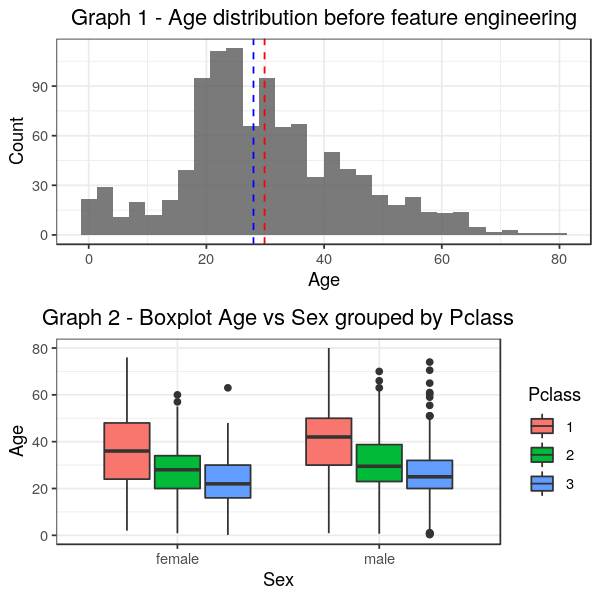

In [14]:
g1 <- titanic_data %>%
    ggplot() + 
    geom_histogram(aes(Age), na.rm = T,alpha= 0.8, bins = 30) +
    geom_vline(aes(xintercept = mean(Age, na.rm = T)),
               color = "red", linetype = "dashed", size =.5) +
    geom_vline(aes(xintercept = median(Age, na.rm = T)),
               color = "blue", linetype = "dashed", size =.5) +
    labs(x = "Age", y = "Count") +  theme_bw() +  
    ggtitle('Graph 1 - Age distribution before feature engineering') +
    theme(plot.title = element_text(hjust = 0.5))   

g2 <- titanic_data %>%
    ggplot() +
    geom_boxplot(aes(x = Sex, y = Age, fill = as.factor(Pclass)),na.rm = T) +
    labs(x = 'Sex', y = 'Age') + 
    scale_fill_discrete(name = "Pclass") + theme_bw() +     
    ggtitle('Graph 2 - Boxplot Age vs Sex grouped by Pclass') + 
    theme(plot.title = element_text(hjust = 0.5)) 


ggarrange(g1, g2, nrow = 2)


In [15]:
#Calculate the median grouped by the Pclass and Sex = male
Mgroup1 <- titanic_data %>% filter(Pclass == 1, Sex == 'male')
Mmedian1 <- median(Mgroup1$Age,na.rm = T)

Mgroup2 <- titanic_data %>% filter(Pclass == 2, Sex == 'male') 
Mmedian2 <- median(Mgroup2$Age,na.rm = T)

Mgroup3 <- titanic_data %>% filter(Pclass == 3, Sex == 'male') 
Mmedian3 <- median(Mgroup3$Age,na.rm = T)



In [16]:
#Calculate the median grouped by the Pclass and Sex = female
Fgroup1 <- titanic_data %>% na.omit() %>% filter(Pclass == 1, Sex == 'female')
Fmedian1 <- median(Fgroup1$Age,na.rm = T)

Fgroup2 <- titanic_data %>% na.omit() %>% filter(Pclass == 2, Sex == 'female') 
Fmedian2 <-median(Fgroup2$Age,na.rm = T)

Fgroup3 <- titanic_data %>% na.omit() %>% filter(Pclass == 3, Sex == 'female') 
Fmedian3 <-median(Fgroup3$Age,na.rm = T)


In [17]:
# Fill the Age's NULL values with median of respective group 
for(i in 1:dim(titanic_data)[1]){
    if(titanic_data$Sex[i] == 'male' && is.na(titanic_data$Age[i])){
        if(titanic_data$Pclass[i] == 1)
            titanic_data$Age[i] <-  Mmedian1
        if(titanic_data$Pclass[i] == 2)
             titanic_data$Age[i] <- Mmedian2
        if(titanic_data$Pclass[i] == 3)
             titanic_data$Age[i] <- Mmedian3
    }
     if(titanic_data$Sex[i] == 'female' && is.na(titanic_data$Age[i])){
        if(titanic_data$Pclass[i] == 1)
            titanic_data$Age[i] <-  Fmedian1
        if(titanic_data$Pclass[i] == 2)
             titanic_data$Age[i] <- Fmedian2
        if(titanic_data$Pclass[i] == 3)
             titanic_data$Age[i] <- Fmedian3
    }
}


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.17   22.00   26.00   29.34   36.00   80.00 

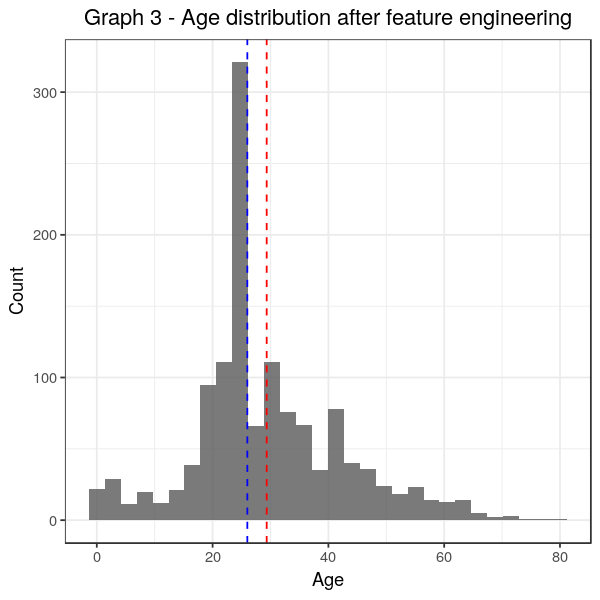

In [18]:
# Show Age summary
summary(titanic_data$Age)

# Plot age distribution
g3 <- titanic_data %>%
    ggplot() + 
    geom_histogram(aes(Age),alpha= 0.8, bins = 30) +
    geom_vline(aes(xintercept = mean(Age, na.rm = T)),
               color = "red", linetype = "dashed", size =.5) +
    geom_vline(aes(xintercept = median(Age, na.rm = T)),
               color = "blue", linetype = "dashed", size =.5) +
    labs(x = "Age", y = "Count") +  theme_bw() +  
    ggtitle('Graph 3 - Age distribution after feature engineering') +
    theme(plot.title = element_text(hjust = 0.5))   
g3



### Missing values of Deck

In [19]:
# If Cabin value is NULL, store Deck value as 'Unknown'
titanic_data$Deck[is.na(titanic_data$Cabin)] <- 'Unknown'

### Missing values of Fare

In [20]:
# Get the position(passenger ID) where Fare's value is NULL.  
id_fare_na <- which(is.na(titanic_data$Fare))
id_fare_na

[1] 1044

In [21]:
titanic_data[id_fare_na,(3:12)]


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,NA,S


In [22]:
# Get the mean and median to Pclass 3 and Embarked S
fare_summary_3S <- titanic_data  %>% 
    filter(Embarked == 'S', Pclass == 3)  %>% 
    summarise("Mean" = mean(Fare, na.rm = T), "Median" = median(Fare, na.rm = T))

fare_summary_3S

Mean,Median
14.43542,8.05


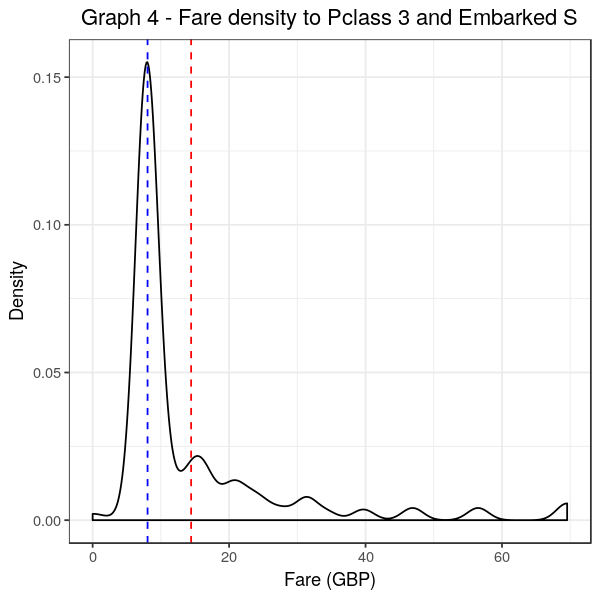

In [23]:
# Plot fare density to Pclass 3 and Embarked S
g4 <- titanic_data[titanic_data$Pclass == '3' & titanic_data$Embarked == 'S',] %>%
    ggplot() + 
    geom_density(aes(Fare), na.rm = T) +
    geom_vline(aes(xintercept = mean(Fare, na.rm = T)),
               color = "red", linetype = "dashed", size =.5) +
    geom_vline(aes(xintercept = median(Fare, na.rm = T)),
               color = "blue", linetype = "dashed", size =.5) +
    labs(x = "Fare (GBP)", y = "Density") +  theme_bw() +  
    ggtitle('Graph 4 - Fare density to Pclass 3 and Embarked S') +
    theme(plot.title = element_text(hjust = 0.5))   
g4


In [24]:
# Replace the missing value with the already calculated median for Pclass 3 and Embarked S
fare_median_3S <- fare_summary_3S[1,2]
titanic_data$Fare[1044] <- fare_median_3S

###  Missing values of Embarked

In [25]:
# Get the position(passenger ID) where Embarked's value is NULL.  
ids_embarked_na <- which(is.na(titanic_data$Embarked))
ids_embarked_na
titanic_data[ids_embarked_na, (3:12)]

[1]  62 830

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
62,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NA
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NA


In [26]:
# Get the mean and median to Pclass 3 and Embarked S
embarked_summary_1 <- titanic_data  %>% 
    filter(Pclass == 1)  %>%
    group_by(Embarked)  %>%
    na.omit() %>% 
    summarise("Mean" = mean(Fare, na.rm = T), 
              "Median" = median(Fare, na.rm = T))

embarked_summary_1

Embarked,Mean,Median
C,105.39274,78.73335
Q,90.00000,90.00000
S,73.65609,53.10000


In [27]:
## Replace the missing values with Embarked == 'C'
titanic_data$Embarked[ids_embarked_na] <- 'C'

In [28]:
#Check for missing values by feature
sapply(titanic_data, function(x) sum(is.na(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0           0 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           0 
 FamilySize       Title      Title2        Deck 
          0           0           0           0

# Exploratory data analysis

## Data summary

In [29]:
titanic_data %>% 
 tabyl(Sex) %>%
 adorn_pct_formatting(digits = 1)

Sex,n,percent
female,466,35.6%
male,843,64.4%


# Prediction

In [198]:
# Create a subset with only the insteresting features
titanic_data_sub <- subset(titanic_data, select = c(2,3,5,6,10,12,13,15,16))

# Convert the categorical features to factor
titanic_data_sub$Survived <- as.factor(titanic_data_sub$Survived)
titanic_data_sub$Pclass <- as.factor(titanic_data_sub$Pclass)
titanic_data_sub$Sex <- as.factor(titanic_data_sub$Sex)
titanic_data_sub$Embarked <- as.factor(titanic_data_sub$Embarked)
titanic_data_sub$Title2 <- as.factor(titanic_data_sub$Title2)
titanic_data_sub$Deck <- as.factor(titanic_data_sub$Deck)
# Show the chosen features
head(titanic_data_sub,3)

Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title2,Deck
0,3,male,22,7.2500,S,2,Mr,Unknown
1,1,female,38,71.2833,C,2,Mrs,C
1,3,female,26,7.9250,S,1,Miss,Unknown


In [199]:
# Split the subset into a train and a test subset
train2 <- titanic_data_sub[1:891,]
test2 <- titanic_data_sub[892:1309,]

## Logistic Regression

In [200]:
# Create a fitted model
fitted_model <- glm(Survived ~.,family=binomial(link='logit'), data=train2)
summary(fitted_model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5291  -0.5519  -0.3719   0.5271   2.4948  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   8.469862   1.351884   6.265 3.72e-10 ***
Pclass2      -0.519116   0.479724  -1.082 0.279202    
Pclass3      -1.578394   0.485838  -3.249 0.001159 ** 
Sexmale      -3.482753   0.964432  -3.611 0.000305 ***
Age          -0.032043   0.009856  -3.251 0.001149 ** 
Fare          0.003967   0.002872   1.381 0.167203    
EmbarkedQ    -0.180674   0.394797  -0.458 0.647212    
EmbarkedS    -0.467363   0.256910  -1.819 0.068886 .  
FamilySize   -0.471095   0.086302  -5.459 4.80e-08 ***
Title2Miss   -3.892847   1.099697  -3.540 0.000400 ***
Title2Mr     -3.339105   0.535594  -6.234 4.54e-10 ***
Title2Mrs    -2.973273   1.063288  -2.796 0.005169 ** 
DeckB        -0.028674   0.748415  -0.038 0.969438    
DeckC      

In [201]:
# Perform a stepwise regression with Backwards elimination approach to find the parsimonious model
backward_model1 <- stepAIC(fitted_model, direction = "backward", 
                      trace = FALSE)
summary(backward_model1)


Call:
glm(formula = Survived ~ Pclass + Sex + Age + Fare + FamilySize + 
    Title2, family = binomial(link = "logit"), data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4683  -0.5539  -0.3809   0.5343   2.5514  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  8.502265   1.211089   7.020 2.21e-12 ***
Pclass2     -1.277937   0.327185  -3.906 9.39e-05 ***
Pclass3     -2.327813   0.325860  -7.144 9.09e-13 ***
Sexmale     -3.772947   0.916606  -4.116 3.85e-05 ***
Age         -0.032112   0.009572  -3.355 0.000794 ***
Fare         0.003936   0.002602   1.513 0.130352    
FamilySize  -0.488471   0.084169  -5.803 6.50e-09 ***
Title2Miss  -4.236563   1.049951  -4.035 5.46e-05 ***
Title2Mr    -3.440212   0.521287  -6.599 4.13e-11 ***
Title2Mrs   -3.344553   1.016557  -3.290 0.001002 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null devian

In [204]:
# Prediction
fitted.results <- predict(backward_model1,newdata=subset(test2,type='response'))
fitted.results <- ifelse(fitted.results > 0.5,1,0)

solution <- data.frame(PassengerID = test$PassengerId, Survived = fitted.results)


In [205]:
gender_submission <- read.csv('gender_submission.csv', stringsAsFactors = F, header=T, na.strings=c(""))
gender_submission$Survived <- as.factor(gender_submission$Survived)
solution$Survived <- as.factor(solution$Survived)
#Accuracy
misClasificError <- mean(solution$Survived != gender_submission$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.909090909090909"


In [206]:
# Write the solution to file
write.csv(solution, file = 'Solution.csv', row.names = F)

## Random Forest

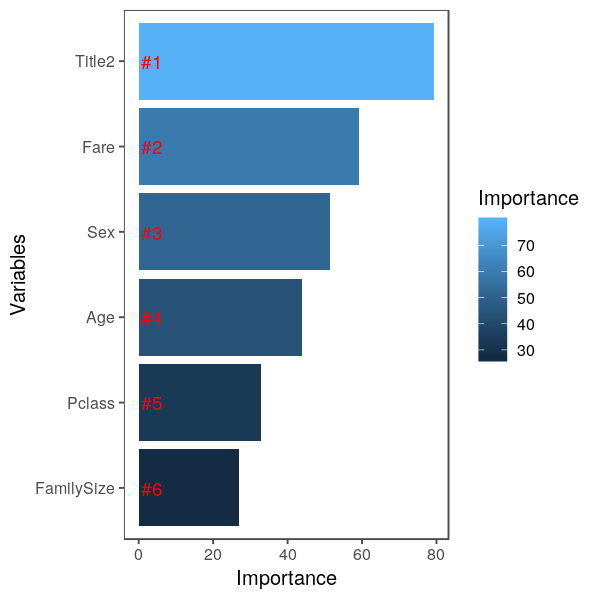

In [221]:
# Use the already parsimonious formula to fit a random forest model
randomForest_model <- randomForest(formula(backward_model1), data = train2)

# Get importance
importance    <- importance(randomForest_model)
varImportance <- data.frame(Variables = row.names(importance), 
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))

# Create a rank variable based on importance
rankImportance <- varImportance %>%
  mutate(Rank = paste0('#',dense_rank(desc(Importance))))

# Use ggplot2 to visualize the relative importance of variables
ggplot(rankImportance, aes(x = reorder(Variables, Importance), 
    y = Importance, fill = Importance)) +
  geom_bar(stat='identity') + 
  geom_text(aes(x = Variables, y = 0.5, label = Rank),
    hjust=0, vjust=0.55, size = 4, colour = 'red') +
  labs(x = 'Variables') +
  coord_flip() + 
  theme_few()

In [222]:
# Predict using the test set
prediction <- predict(randomForest_model, test2)

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution_rf <- data.frame(PassengerID = test$PassengerId, Survived = prediction)

misClasificError <- mean(solution_rf$Survived != gender_submission$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.904306220095694"


In [223]:
# Write the solution to file
write.csv(solution, file = 'rf_Solution.csv', row.names = F)

## Decision Tree



In [264]:
output.tree <- ctree(backward_model1, data = train2)
rpred <- predict(output.tree, newdata=test2)

# References